# Working with morphologies

In this tutorial, you will learn how to:

- Load morphologies and make them compatible with `Jaxley`  
- Use the visualization features  
- Assemble a small network of morphologically accurate cells.  
- Delete parts of a morphology.
- Connect two morphologies into one.

Here is a code snippet which you will learn to understand in this tutorial:


```python
import jaxley as jx
from jaxley.io.morph_utils import morph_attach, morph_delete

# Read cell from SWC.
cell = jx.read_swc("my_cell.swc", ncomp=1)

# Delete the apical dendrite.
cell = morph_delete(cell.apical)

# Attach a "stub" to the cell.
stub = jx.Cell()
cell = morph_attach(cell.branch(0).loc(0.0), stub.branch(0).loc(0.0))

# Modify the number of compartments of a branch.
cell.branch(2).set_ncomp(4)
```

In [1]:
import jaxley as jx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from jaxley.channels import HH
from jaxley.synapses import IonotropicSynapse

### Importing SWC files

To work with `.swc` files, `Jaxley` implements a custom `.swc` reader. The reader traces the morphology and identifies all uninterrupted sections. These uninterrupted sections are called `branches` in `Jaxley`. Each `branch` is then further partitioned into `compartments`.

To demonstrate this, let's import an example morphology of a Layer 5 pyramidal cell and visualize it.

In [2]:
# import swc file into jx.Cell object
fname = "data/morph.swc"
cell = jx.read_swc(fname, ncomp=1)  # Use one compartment per branch. We modify this below.

# print shape (num_branches, num_comps)
print(cell.shape)

cell.show()

(157, 157)


,local_comp_index,global_comp_index,local_branch_index,global_branch_index,local_cell_index,global_cell_index
0,0,0,0,0,0,0
1,0,1,1,1,0,0
2,0,2,2,2,0,0
3,0,3,3,3,0,0
4,0,4,4,4,0,0
...,...,...,...,...,...,...
152,0,152,152,152,0,0
153,0,153,153,153,0,0
154,0,154,154,154,0,0
155,0,155,155,155,0,0


As we can see, this yields a morphology that is approximated by 157 compartments. The above assigns one compartment to every branch (`ncomp=1`). To use a different number of compartments in individual branches, you can use `.set_ncomp()`:

In [3]:
cell.branch(1).set_ncomp(4)

As you can see below, branch `0` has two compartments (because this is what was passed to `jx.read_swc(..., ncomp=2)`), but branch `1` has four compartments:

In [4]:
cell.branch([0, 1]).nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,soma,basal,apical,custom,global_cell_index,global_branch_index,global_comp_index,controlled_by_param
0,0,0,0,0.100000,8.119000,5000.0,1.0,-70.0,False,False,False,True,0,0,0,0
1,0,1,0,3.120779,7.806172,5000.0,1.0,-70.0,True,False,False,False,0,1,1,1
2,0,1,1,3.120779,7.111231,5000.0,1.0,-70.0,True,False,False,False,0,1,2,1
3,0,1,2,3.120779,5.652394,5000.0,1.0,-70.0,True,False,False,False,0,1,3,1
4,0,1,3,3.120779,3.869247,5000.0,1.0,-70.0,True,False,False,False,0,1,4,1


## Visualization

Once imported the compartmentalized morphology can be viewed using `vis`.  

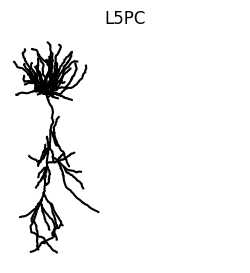

In [5]:
# visualize the cell
cell.vis()
plt.axis("off")
plt.title("L5PC")
plt.axis("square")
plt.show()

`vis` can be called on any `jx.Module` and every `View` of the module. This means we can also for example use `vis` to highlight each branch. This can be done by iterating over each branch index and calling `cell.branch(i).vis()`. Within the loop.

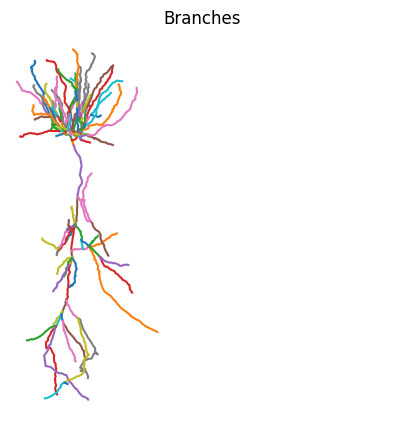

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# define colorwheel with 10 colors
colors = plt.cm.tab10.colors
for i, branch in enumerate(cell.branches):
    branch.vis(ax=ax, color=colors[i % 10])
plt.axis("off")
plt.title("Branches")
plt.axis("square")
plt.show()

While we only use two compartments to approximate each branch in this example, we can see the morphology is still plotted in great detail. This is because we always plot the full `.swc` reconstruction irrespective of the number of compartments used. The morphology lives seperately in the `cell.xyzr` attribute in a per branch fashion. 

In addition to plotting the full morphology of the cell using points `vis(type="scatter")` or lines `vis(type="line")`, `Jaxley` also supports plotting a detailed morphological `vis(type="morph")` or approximate compartmental reconstruction `vis(type="comp")` that correctly considers the thickness of the neurite. Note that `"comp"` plots the lengths of each compartment which is equal to the length of the traced neurite. While neurites can be zigzaggy, the compartments that approximate them are straight lines. This can lead to miss-aligment of the compartment ends. For details see the documentation of `vis`. 

The morphologies can either be projected onto 2D or also rendered in 3D. 

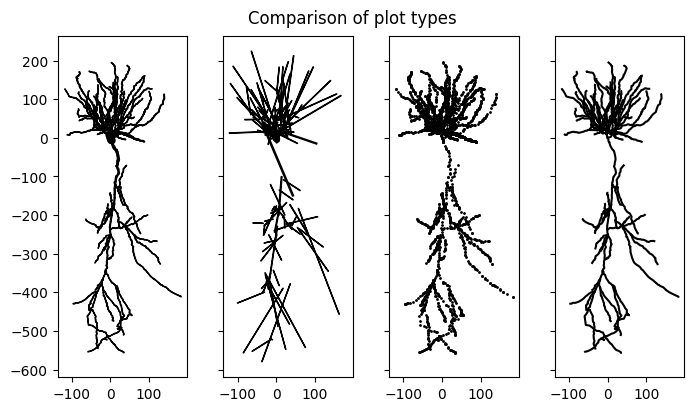

In [7]:
# visualize the cell
fig, ax = plt.subplots(1, 4, figsize=(7, 4), layout="constrained", sharex=True, sharey=True)
cell.vis(ax=ax[0], type="morph", dims=[0,1])
cell.vis(ax=ax[1], type="comp", dims=[0,1])
cell.vis(ax=ax[2], type="scatter", dims=[0,1], s=1)
cell.vis(ax=ax[3], type="line", dims=[0,1])
fig.suptitle("Comparison of plot types")
for i in range(4):
    ax[i].set_aspect('equal', adjustable='box')
plt.show()

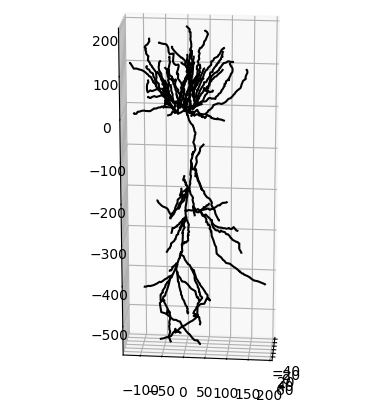

In [8]:
# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cell.vis(ax=ax, type="line", dims=[2,0,1])
ax.view_init(elev=20, azim=5)
ax.set_aspect('equal', adjustable='box')
plt.show()

Since `Jaxley` supports grouping different branches or compartments together, we can also use the `id` labels provided by the `.swc` file to assign group labels to the `jx.Cell` object.

['soma', 'basal', 'apical', 'custom']


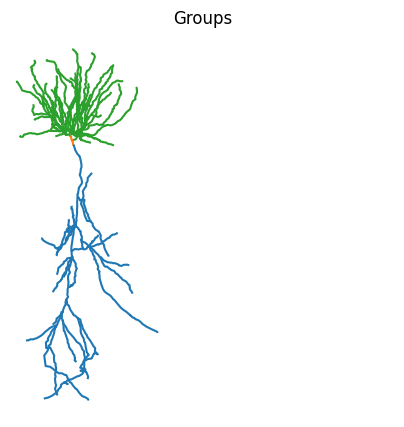

In [9]:
print(cell.group_names)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = plt.cm.tab10.colors
cell.basal.vis(ax=ax, color=colors[2])
cell.soma.vis(ax=ax, color=colors[1])
cell.apical.vis(ax=ax, color=colors[0])
plt.axis("off")
plt.title("Groups")
plt.axis("square")
plt.show()

## Editing morphologies

`Jaxley` also provides functionality to edit morphologies. If you edit morphologies, please do so _before_ you change the number of compartments per branch (via, e.g., `cell.branch(0).set_ncomp(4)`), _before_ you insert channels, recordings, and stimuli, and _before_ you make parameters trainable.

Below, we will show how you can delete all apical branches of a morphology. To do so, we first import the morphology:

In [61]:
import jaxley as jx

fname = "data/morph.swc"
cell = jx.read_swc(fname, ncomp=1)

We then use the `morph_delete` method to delete parts of the morphology:

In [63]:
from jaxley.io.morph_utils import morph_delete

# Creates a new cell which has the apical dendrite deleted.
cell = morph_delete(cell.apical)

To check if everything worked, we visualize the resulting morphology (soma highlighted in red):

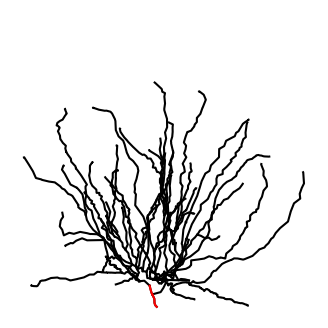

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = cell.vis(ax=ax)
ax = cell.soma.vis(ax=ax, color="r")
_ = plt.axis("off")
_ = plt.axis("square")

`Jaxley` also provides functionality to attach two morphologies. This is useful to, for example, replace the axon with a "stub". Below, we show how one can attach two morphologies. To this end, we first create a small "stub" consisting of just a single compartment, which we will attach to the morphology above.

> **⚠️ IMPORTANT!**  
> You must use the same `ncomp` for both morphologies! You can always modify the number of compartments per branch with `cell.branch(0).set_ncomp(n)` afterwards.

In [67]:
# Create a "stub" of 50um length from scratch.
stub = jx.Cell()
stub.set("length", 50.0)

# Rotate the stub. This is only used for visualization.
stub.compute_xyz()
stub.rotate(90)

Once the two morphologies are defined, we can use `morph_attach` to combine two cells into one:

In [68]:
from jaxley.io.morph_utils import morph_attach

new_cell = morph_attach(cell.branch(0).loc(0.0), stub.branch(0).loc(0.0))

Let's visualize the cell before and after having added the stub:

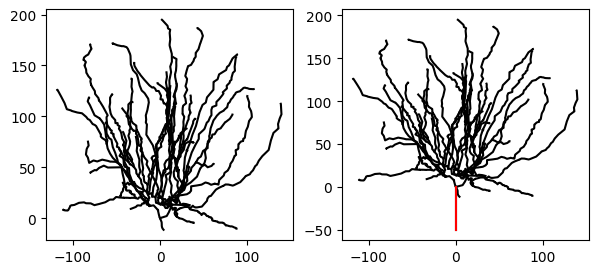

In [70]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
_ = cell.vis(ax=ax[0])
_ = new_cell.vis(ax=ax[1])
_ = new_cell.branch(2).vis(ax=ax[1], color="r")

Indeed, the new morphology has an additional stub, which we highlighted in red.

## Assembling cells into a network

To build a network of morphologically detailed cells, we can now connect several reconstructed cells together and also visualize the network. However, since all cells are going to have the same center, `Jaxley` will naively plot all of them on top of each other. To seperate out the cells, we therefore have to move them to a new location first.

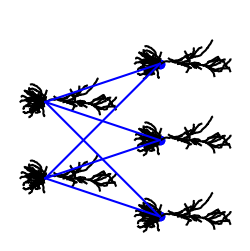

In [12]:
fname = "data/morph.swc"
cell = jx.read_swc(fname, ncomp=1)

net = jx.Network([cell]*5)
jx.connect(net[0,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[0,0,0], net[4,0,0], IonotropicSynapse())

jx.connect(net[1,0,0], net[2,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[3,0,0], IonotropicSynapse())
jx.connect(net[1,0,0], net[4,0,0], IonotropicSynapse())

net.rotate(-90)

net.cell(0).move(0, 900)
net.cell(1).move(0, 1500)

net.cell(2).move(900, 600)
net.cell(3).move(900, 1200)
net.cell(4).move(900, 1800)

net.vis()
plt.axis("off")
plt.axis("square")
plt.show()

Congrats! You have now learned how to vizualize and build networks out of very complex morphologies. To simulate this network, you can follow the steps in the tutorial on [how to build a network](https://jaxley.readthedocs.io/en/latest/tutorials/02_small_network.html) or continue to learn about how you can interface with `networkX`.